In [3]:
# import libraries
import numpy as np
import pandas as pd
import swat as sw
import os
#os.environ['CUDA_VISIBLE_DEVICES']='1'
os.environ['CUDA_VISIBLE_DEVICES']='0'
import warnings
warnings.filterwarnings("ignore")

In [4]:
adult_data = pd.read_csv('../gan-testing/data/adult.csv')
adult_discrete_columns = "workclass,education,marital-status,occupation,relationship,race,sex,native-country,label".split(',')
adult_data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
48838,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


In [24]:
# remove some extra charachters
adult_data = adult_data.replace({'\$': '', ',': ''}, regex=True)
adult_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [25]:
# replace the target >50K & <=50K with 1, 0
adult_data.loc[adult_data['label']=='>50K', 'label'] = 1
adult_data.loc[adult_data['label']=='<=50K', 'label'] = 0 # use this as input to the GAN
unique_labels = adult_data['label'].unique()
unique_labels

array([0, 1], dtype=object)

In [26]:
adult_data.replace('?', np.nan, inplace=True)
adult_data=adult_data.fillna(adult_data.mean())
adult_data = adult_data.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [27]:
# try using the Ruiwen's Encoder for ML utility and CTGAN transformer for GAN
str_cols= [ 'workclass', 'education', 'marital-status', 'relationship','race', 'sex','native-country']
num_cols = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week', 'label']
dataframe = pd.DataFrame(adult_data.loc[:,str_cols])

one_hot_columns = pd.DataFrame()
for col_name, item in dataframe.iteritems():
    
    #print(col_name)
    #print(item)
    col = pd.get_dummies(item, prefix=col_name)
    one_hot_columns =pd.concat([one_hot_columns,col],axis=1)
one_hot_columns.head()  

,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# entire data is concat of discrete and contiuous cols
adult_data_all = pd.concat([one_hot_columns,adult_data.loc[:,num_cols]],axis=1)
#adult_data_all.head()
my_X = adult_data_all.drop(["label"],axis=1)
orig_X, orig_y = my_X,adult_data_all.loc[:,"label"]

In [29]:
from sklearn.model_selection import train_test_split

orig_X_train, orig_X_test, orig_y_train, orig_y_test = train_test_split(orig_X, orig_y, test_size=0.3, random_state=123)
my_data1_train = pd.concat([orig_X_train,orig_y_train],axis=1)
my_data1_test = pd.concat([orig_X_test,orig_y_test],axis=1)
#my_data1_test.describe()
orig_y_train = orig_y_train.astype('int')
orig_y_test = orig_y_test.astype('int')

In [30]:
# train ML models on the train set of the original data
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
names = ["Decision Tree","Linear SVM", "Random Forest", "Logistic Regression","MLP"]

classifiers = [
    DecisionTreeClassifier(max_depth=5,random_state=0),
    SVC(kernel = 'linear', max_iter=1000, C=0.025, random_state=0, probability=True),
    RandomForestClassifier(n_estimators=200, random_state=0),
    LogisticRegression(max_iter=1000, random_state=0),
    MLPClassifier(alpha=1, max_iter=1000, random_state=0)]

In [31]:
print('ML scores for the original data:')
for name, clf in zip(names, classifiers):
    clf.fit(orig_X_train, orig_y_train)
    score = clf.score(orig_X_test, orig_y_test)
    y_pred = clf.predict(orig_X_test)
    Acc = accuracy_score(orig_y_test, y_pred)
    fscore = f1_score(orig_y_test, y_pred, average='binary')
    AUC = roc_auc_score(orig_y_test, clf.predict_proba(orig_X_test)[:, 1])
    print(name,'Acc: ', Acc, 'f-1: ', fscore, 'AUC:', AUC)


ML scores for the original data:
Decision Tree Acc:  0.8537500853067631 f-1:  0.6328593455542231 AUC: 0.8863975382887572
Linear SVM Acc:  0.2956391182692964 f-1:  0.368089144676422 AUC: 0.509806196049388
Random Forest Acc:  0.8495188698560022 f-1:  0.6575555210436402 AUC: 0.8977741254446227
Logistic Regression Acc:  0.80017743806729 f-1:  0.3851322973540529 AUC: 0.5769572159245973
MLP Acc:  0.7840715211902 f-1:  0.43419170243204575 AUC: 0.668529384827481


In [32]:
# # now input the data to CPCTGAN and train
# adult_discrete_columns = adult_discrete_columns[:-1]
adult_discrete_columns

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country',
 'label']

In [33]:
# get the train data for gan with same seed as the ML utility
GAN_X = adult_data.drop(["label"],axis=1)
GAN_orig_X, GAN_orig_y = GAN_X,adult_data.loc[:,"label"]

In [34]:
from sklearn.model_selection import train_test_split

GAN_X_train, GAN_X_test, GAN_y_train, GAN_y_test = train_test_split(GAN_orig_X, GAN_orig_y, test_size=0.3, random_state=123)
GAN_data_train = pd.concat([GAN_X_train,GAN_y_train],axis=1)
GAN_data_test = pd.concat([GAN_X_test,GAN_y_test],axis=1)
#my_data1_test.describe()

In [35]:
s = sw.CAS('dl2073.clstr.rnd.sas.com',33789)

In [36]:
s.loadactionset('generativeAdversarialNet')

NOTE: Added action set 'generativeAdversarialNet'.


[actionset]

 'generativeAdversarialNet'

+ Elapsed: 0.334s, user: 3.55s, sys: 2.91s, mem: 0.222mb

In [37]:
s.upload(GAN_data_train, casout=dict(name='GAN_data_train', replace=True))

NOTE: Cloud Analytic Services made the uploaded file available as table GAN_DATA_TRAIN in caslib CASUSER(alphel).
NOTE: The table GAN_DATA_TRAIN has been created in caslib CASUSER(alphel) from binary data uploaded to Cloud Analytic Services.


[caslib]

 'CASUSER(alphel)'

[tableName]

 'GAN_DATA_TRAIN'

[casTable]

 CASTable('GAN_DATA_TRAIN', caslib='CASUSER(alphel)')

+ Elapsed: 0.0966s, user: 0.261s, sys: 0.0435s, mem: 126mb

In [38]:
cen = pd.read_csv("../gan-testing/data/adult_centroids.csv")
s.upload(cen, casout=dict(name='cen', replace=True))
cen

NOTE: Cloud Analytic Services made the uploaded file available as table CEN in caslib CASUSER(alphel).
NOTE: The table CEN has been created in caslib CASUSER(alphel) from binary data uploaded to Cloud Analytic Services.


,VarName,Centroid-i,weight,Mean,Std
0,hours-per-week,1,0.19322,27.77,11.92
1,hours-per-week,2,0.46569,40.00,0.10
2,hours-per-week,3,0.05051,53.80,6.97
3,hours-per-week,4,0.13165,52.02,20.72
4,hours-per-week,5,0.05105,53.95,7.23
5,hours-per-week,6,0.10788,48.49,2.39
6,age,1,0.14270,31.37,8.39
7,age,2,0.18711,26.35,5.90
8,age,3,0.16313,43.14,12.26
9,age,4,0.14163,36.40,10.26


In [39]:
results = s.tabularGanTrain(
table = {"name":"GAN_data_train"},
    centroidsTable= "cen",
    gpu = 1,
    nominals = adult_discrete_columns,
    optimizerAe ={"method":'ADAM',"numEpochs":500},
    optimizerGan ={"method":'ADAM',"numEpochs":500},
    seed = 12345,
    scoreSeed = 1234,
    numSamples =50000,
    saveState ={"name":"cpctStore", "replace":True},
    casOut = {"name":"out", "replace":True}
)
results

NOTE: Using device: GPU 0.
NOTE: Epoch i=1, ae_loss=  0.0495.
NOTE: Epoch i=2, ae_loss=  0.0378.
NOTE: Epoch i=3, ae_loss=  0.0293.
NOTE: Epoch i=4, ae_loss=  0.0231.
NOTE: Epoch i=5, ae_loss=  0.0203.
NOTE: Epoch i=6, ae_loss=  0.0194.
NOTE: Epoch i=7, ae_loss=  0.0180.
NOTE: Epoch i=8, ae_loss=  0.0164.
NOTE: Epoch i=9, ae_loss=  0.0154.
NOTE: Epoch i=10, ae_loss=  0.0138.
NOTE: Epoch i=11, ae_loss=  0.0137.
NOTE: Epoch i=12, ae_loss=  0.0138.
NOTE: Epoch i=13, ae_loss=  0.0133.
NOTE: Epoch i=14, ae_loss=  0.0125.
NOTE: Epoch i=15, ae_loss=  0.0120.
NOTE: Epoch i=16, ae_loss=  0.0117.
NOTE: Epoch i=17, ae_loss=  0.0119.
NOTE: Epoch i=18, ae_loss=  0.0110.
NOTE: Epoch i=19, ae_loss=  0.0117.
NOTE: Epoch i=20, ae_loss=  0.0112.
NOTE: Epoch i=21, ae_loss=  0.0119.
NOTE: Epoch i=22, ae_loss=  0.0101.
NOTE: Epoch i=23, ae_loss=  0.0111.
NOTE: Epoch i=24, ae_loss=  0.0097.
NOTE: Epoch i=25, ae_loss=  0.0096.
NOTE: Epoch i=26, ae_loss=  0.0104.
NOTE: Epoch i=27, ae_loss=  0.0098.
NOTE: Epoc

NOTE: Epoch i=226, ae_loss=  0.0062.
NOTE: Epoch i=227, ae_loss=  0.0057.
NOTE: Epoch i=228, ae_loss=  0.0068.
NOTE: Epoch i=229, ae_loss=  0.0066.
NOTE: Epoch i=230, ae_loss=  0.0062.
NOTE: Epoch i=231, ae_loss=  0.0062.
NOTE: Epoch i=232, ae_loss=  0.0058.
NOTE: Epoch i=233, ae_loss=  0.0061.
NOTE: Epoch i=234, ae_loss=  0.0059.
NOTE: Epoch i=235, ae_loss=  0.0064.
NOTE: Epoch i=236, ae_loss=  0.0064.
NOTE: Epoch i=237, ae_loss=  0.0075.
NOTE: Epoch i=238, ae_loss=  0.0068.
NOTE: Epoch i=239, ae_loss=  0.0061.
NOTE: Epoch i=240, ae_loss=  0.0061.
NOTE: Epoch i=241, ae_loss=  0.0059.
NOTE: Epoch i=242, ae_loss=  0.0059.
NOTE: Epoch i=243, ae_loss=  0.0055.
NOTE: Epoch i=244, ae_loss=  0.0064.
NOTE: Epoch i=245, ae_loss=  0.0055.
NOTE: Epoch i=246, ae_loss=  0.0060.
NOTE: Epoch i=247, ae_loss=  0.0065.
NOTE: Epoch i=248, ae_loss=  0.0063.
NOTE: Epoch i=249, ae_loss=  0.0061.
NOTE: Epoch i=250, ae_loss=  0.0057.
NOTE: Epoch i=251, ae_loss=  0.0065.
NOTE: Epoch i=252, ae_loss=  0.0061.
N

NOTE: Epoch i=450, ae_loss=  0.0056.
NOTE: Epoch i=451, ae_loss=  0.0051.
NOTE: Epoch i=452, ae_loss=  0.0058.
NOTE: Epoch i=453, ae_loss=  0.0053.
NOTE: Epoch i=454, ae_loss=  0.0055.
NOTE: Epoch i=455, ae_loss=  0.0059.
NOTE: Epoch i=456, ae_loss=  0.0055.
NOTE: Epoch i=457, ae_loss=  0.0053.
NOTE: Epoch i=458, ae_loss=  0.0050.
NOTE: Epoch i=459, ae_loss=  0.0060.
NOTE: Epoch i=460, ae_loss=  0.0061.
NOTE: Epoch i=461, ae_loss=  0.0046.
NOTE: Epoch i=462, ae_loss=  0.0053.
NOTE: Epoch i=463, ae_loss=  0.0055.
NOTE: Epoch i=464, ae_loss=  0.0057.
NOTE: Epoch i=465, ae_loss=  0.0060.
NOTE: Epoch i=466, ae_loss=  0.0046.
NOTE: Epoch i=467, ae_loss=  0.0054.
NOTE: Epoch i=468, ae_loss=  0.0053.
NOTE: Epoch i=469, ae_loss=  0.0057.
NOTE: Epoch i=470, ae_loss=  0.0056.
NOTE: Epoch i=471, ae_loss=  0.0053.
NOTE: Epoch i=472, ae_loss=  0.0052.
NOTE: Epoch i=473, ae_loss=  0.0058.
NOTE: Epoch i=474, ae_loss=  0.0050.
NOTE: Epoch i=475, ae_loss=  0.0050.
NOTE: Epoch i=476, ae_loss=  0.0050.
N

NOTE: Epoch i=126, g_loss=  0.6079, d_loss=  0.0305.
NOTE: Epoch i=127, g_loss=  0.9209, d_loss= -0.1238.
NOTE: Epoch i=128, g_loss=  0.9482, d_loss= -0.0740.
NOTE: Epoch i=129, g_loss=  0.9777, d_loss= -0.1693.
NOTE: Epoch i=130, g_loss=  1.1318, d_loss= -0.1013.
NOTE: Epoch i=131, g_loss=  1.3120, d_loss= -0.1797.
NOTE: Epoch i=132, g_loss=  1.3739, d_loss= -0.0940.
NOTE: Epoch i=133, g_loss=  1.3707, d_loss= -0.0776.
NOTE: Epoch i=134, g_loss=  1.2097, d_loss= -0.3083.
NOTE: Epoch i=135, g_loss=  1.1325, d_loss=  0.0268.
NOTE: Epoch i=136, g_loss=  1.0349, d_loss= -0.3362.
NOTE: Epoch i=137, g_loss=  0.9072, d_loss=  0.1278.
NOTE: Epoch i=138, g_loss=  0.8128, d_loss= -0.1848.
NOTE: Epoch i=139, g_loss=  0.7343, d_loss=  0.0009.
NOTE: Epoch i=140, g_loss=  0.7893, d_loss= -0.2975.
NOTE: Epoch i=141, g_loss=  0.6235, d_loss= -0.1008.
NOTE: Epoch i=142, g_loss=  0.5937, d_loss= -0.0566.
NOTE: Epoch i=143, g_loss=  0.7939, d_loss= -0.0567.
NOTE: Epoch i=144, g_loss=  0.8305, d_loss= -0

NOTE: Epoch i=284, g_loss=  1.6334, d_loss= -0.0895.
NOTE: Epoch i=285, g_loss=  1.4680, d_loss= -0.2269.
NOTE: Epoch i=286, g_loss=  1.5628, d_loss= -0.1676.
NOTE: Epoch i=287, g_loss=  1.4248, d_loss= -0.2223.
NOTE: Epoch i=288, g_loss=  1.5286, d_loss= -0.0552.
NOTE: Epoch i=289, g_loss=  1.4662, d_loss=  0.1274.
NOTE: Epoch i=290, g_loss=  1.5974, d_loss= -0.2771.
NOTE: Epoch i=291, g_loss=  1.3954, d_loss= -0.1003.
NOTE: Epoch i=292, g_loss=  1.6258, d_loss=  0.2224.
NOTE: Epoch i=293, g_loss=  1.5923, d_loss=  0.0460.
NOTE: Epoch i=294, g_loss=  1.6112, d_loss= -0.0494.
NOTE: Epoch i=295, g_loss=  1.6493, d_loss= -0.1987.
NOTE: Epoch i=296, g_loss=  1.6990, d_loss=  0.1082.
NOTE: Epoch i=297, g_loss=  1.4387, d_loss= -0.3196.
NOTE: Epoch i=298, g_loss=  1.2837, d_loss= -0.2765.
NOTE: Epoch i=299, g_loss=  1.6081, d_loss= -0.0472.
NOTE: Epoch i=300, g_loss=  1.6310, d_loss= -0.0922.
NOTE: Epoch i=301, g_loss=  1.6276, d_loss= -0.3002.
NOTE: Epoch i=302, g_loss=  1.5985, d_loss= -0

NOTE: Epoch i=439, g_loss=  1.6182, d_loss= -0.1224.
NOTE: Epoch i=440, g_loss=  1.5223, d_loss= -0.2441.
NOTE: Epoch i=441, g_loss=  1.3338, d_loss=  0.0990.
NOTE: Epoch i=442, g_loss=  1.6498, d_loss= -0.3134.
NOTE: Epoch i=443, g_loss=  1.5156, d_loss= -0.1485.
NOTE: Epoch i=444, g_loss=  1.5976, d_loss= -0.1554.
NOTE: Epoch i=445, g_loss=  1.5050, d_loss= -0.3183.
NOTE: Epoch i=446, g_loss=  1.5846, d_loss= -0.2501.
NOTE: Epoch i=447, g_loss=  1.3801, d_loss=  0.1832.
NOTE: Epoch i=448, g_loss=  1.4169, d_loss=  0.0368.
NOTE: Epoch i=449, g_loss=  1.7638, d_loss= -0.0697.
NOTE: Epoch i=450, g_loss=  1.8974, d_loss= -0.2150.
NOTE: Epoch i=451, g_loss=  1.5901, d_loss= -0.2484.
NOTE: Epoch i=452, g_loss=  1.8255, d_loss=  0.0174.
NOTE: Epoch i=453, g_loss=  1.6440, d_loss= -0.1964.
NOTE: Epoch i=454, g_loss=  1.5786, d_loss= -0.1310.
NOTE: Epoch i=455, g_loss=  1.7350, d_loss= -0.1890.
NOTE: Epoch i=456, g_loss=  1.4843, d_loss= -0.1735.
NOTE: Epoch i=457, g_loss=  1.6773, d_loss=  0

,EpochNumber,AutoencoderLoss,GeneratorLoss,DiscriminatorLoss
0,1,0.049489,NaN,NaN
1,2,0.037792,NaN,NaN
2,3,0.029271,NaN,NaN
3,4,0.023146,NaN,NaN
4,5,0.020312,NaN,NaN
...,...,...,...,...
995,496,NaN,1.535579,-0.496610
996,497,NaN,1.348975,-0.157579
997,498,NaN,1.467066,-0.472342
998,499,NaN,1.456292,-0.112555


In [40]:
samples = s.fetch('out', to=400000, maxrows=400000)['Fetch']
gloss = results.IterHistory['GeneratorLoss'].dropna().reset_index(drop=True)
dloss = results.IterHistory['DiscriminatorLoss'].dropna().reset_index(drop=True)

Text(0.5, 1.0, 'Losses for CTGAN on Adult data')

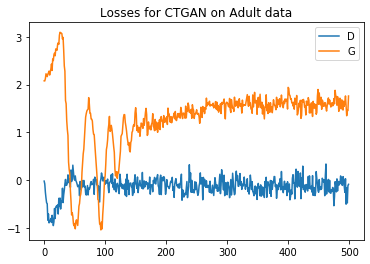

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(dloss)
plt.plot(gloss)
plt.legend(['D', 'G'])
plt.title('Losses for CTGAN on Adult data')
#plt.savefig('Original-CTGAN-Adult')

In [42]:
samples['label'].value_counts()

0.0    41434
1.0     8566
Name: label, dtype: int64

In [43]:
GAN_data_train['label'].value_counts()

0    25989
1     8200
Name: label, dtype: int64

In [44]:
# try using the Ruiwen's Encoder for ML utility and CTGAN transformer for GAN
str_cols= [ 'workclass', 'education', 'marital-status', 'relationship','race', 'sex','native-country']
num_cols = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week', 'label']
dataframe = pd.DataFrame(samples.loc[:,str_cols])

one_hot_columns = pd.DataFrame()
for col_name, item in dataframe.iteritems():
    
    #print(col_name)
    #print(item)
    col = pd.get_dummies(item, prefix=col_name)
    one_hot_columns =pd.concat([one_hot_columns,col],axis=1)
one_hot_columns.head()  

,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [45]:
# entire data is concat of discrete and contiuous cols
fake_all = pd.concat([one_hot_columns,samples.loc[:,num_cols]],axis=1)
#adult_data_all.head()
fake_X = fake_all.drop(["label"],axis=1)
fake_X, fake_y = fake_X,fake_all.loc[:,"label"]

In [46]:
# make sure cols of generated data has the same index sort 
fake_X = fake_X.reindex(adult_data_all.columns,axis=1, fill_value=0) # fill new cols with 0
#len(fake_X.columns)
fake_X = fake_X.drop(["label"],axis=1) # separate X and Y for training
fake_X, fake_y = fake_X,fake_all.loc[:,"label"]

In [47]:
# check the training data shape to agree with the original data (# of features/cols)
print('shape of the GAN generated train data: ',fake_X.shape)
print('shape of the GAN generated labels: ',fake_y.shape)
print('shape of the original test data: ',orig_X_test.shape)
print('number of events in the fake data: ', sum(fake_y))

shape of the GAN generated train data:  (50000, 91)
shape of the GAN generated labels:  (50000,)
shape of the original test data:  (14653, 91)
number of events in the fake data:  8566.0


In [48]:
# train a classifier on the CPCTGAN generated data
classifiers = [
    DecisionTreeClassifier(max_depth=5,random_state=0),
    SVC(kernel = 'linear', max_iter=1000, C=0.025, random_state=0, probability=True),
    RandomForestClassifier(n_estimators=200, random_state=0),
    LogisticRegression(max_iter=1000, random_state=0),
    MLPClassifier(alpha=1, max_iter=1000, random_state=0)]

print('ML scores for the GAN generated data:')
for name, clf in zip(names, classifiers):
    clf.fit(fake_X, fake_y)
    score = clf.score(orig_X_test, orig_y_test)
    y_pred = clf.predict(orig_X_test)
    Acc = accuracy_score(orig_y_test, y_pred)
    fscore = f1_score(orig_y_test, y_pred, average='binary')
    AUC = roc_auc_score(orig_y_test, clf.predict_proba(orig_X_test)[:, 1])
    print(name,'Acc: ', Acc, 'f-1: ', fscore, 'AUC:', AUC)

ML scores for the GAN generated data:
Decision Tree Acc:  0.7981983211629018 f-1:  0.33833072275676884 AUC: 0.8329082108973012
Linear SVM Acc:  0.6241042789872381 f-1:  0.2371191135734072 AUC: 0.49540179457272293
Random Forest Acc:  0.8055688254964853 f-1:  0.41366536324346576 AUC: 0.8575254003753149
Logistic Regression Acc:  0.7668736777451717 f-1:  0.0871191876002138 AUC: 0.4714826251863258
MLP Acc:  0.7690575308810482 f-1:  0.06930693069306931 AUC: 0.6227984231084562


In [49]:
fake_y.value_counts()

0.0    41434
1.0     8566
Name: label, dtype: int64

In [50]:
orig_y_test.value_counts()

0    11166
1     3487
Name: label, dtype: int64

### Train CTGAN on the same data

In [51]:
from ctgan import CTGANSynthesizer

In [52]:
# train CTGAN and generate fake data
ctgan = CTGANSynthesizer(verbose=True)
ctgan.fit(GAN_data_train, adult_discrete_columns, epochs=500)

Epoch 1, Loss G:  1.5204,Loss D: -0.0589
Epoch 2, Loss G:  1.3082,Loss D: -0.0196
Epoch 3, Loss G:  0.3795,Loss D: -0.0636
Epoch 4, Loss G:  0.0595,Loss D: -0.0625
Epoch 5, Loss G: -0.4881,Loss D:  0.0530
Epoch 6, Loss G: -0.8528,Loss D:  0.1767
Epoch 7, Loss G: -0.8646,Loss D: -0.0188
Epoch 8, Loss G: -1.3634,Loss D:  0.1349
Epoch 9, Loss G: -1.6166,Loss D: -0.1497
Epoch 10, Loss G: -1.6396,Loss D: -0.0809
Epoch 11, Loss G: -1.6600,Loss D:  0.0691
Epoch 12, Loss G: -1.5443,Loss D: -0.0439
Epoch 13, Loss G: -1.5796,Loss D:  0.0283
Epoch 14, Loss G: -1.7363,Loss D: -0.0391
Epoch 15, Loss G: -1.8126,Loss D: -0.0799
Epoch 16, Loss G: -1.7884,Loss D: -0.1437
Epoch 17, Loss G: -1.5641,Loss D: -0.2686
Epoch 18, Loss G: -1.3873,Loss D: -0.1432
Epoch 19, Loss G: -1.5918,Loss D: -0.2049
Epoch 20, Loss G: -1.2530,Loss D: -0.1029
Epoch 21, Loss G: -1.2472,Loss D: -0.0676
Epoch 22, Loss G: -1.1067,Loss D: -0.0157
Epoch 23, Loss G: -0.8825,Loss D:  0.1365
Epoch 24, Loss G: -1.1675,Loss D: -0.2641
E

Epoch 195, Loss G: -0.5261,Loss D: -0.0075
Epoch 196, Loss G: -0.5167,Loss D: -0.0146
Epoch 197, Loss G: -0.3848,Loss D:  0.0450
Epoch 198, Loss G: -0.4742,Loss D: -0.0643
Epoch 199, Loss G: -0.2714,Loss D: -0.3152
Epoch 200, Loss G: -0.6815,Loss D:  0.0548
Epoch 201, Loss G: -0.3424,Loss D: -0.7198
Epoch 202, Loss G: -0.4733,Loss D: -0.2780
Epoch 203, Loss G: -0.4560,Loss D: -0.1680
Epoch 204, Loss G: -0.4523,Loss D: -0.2623
Epoch 205, Loss G: -0.3346,Loss D: -0.2298
Epoch 206, Loss G: -0.3219,Loss D: -0.0520
Epoch 207, Loss G: -0.6410,Loss D:  0.0222
Epoch 208, Loss G: -0.6945,Loss D: -0.3104
Epoch 209, Loss G: -0.3281,Loss D: -0.1552
Epoch 210, Loss G: -0.3758,Loss D:  0.0352
Epoch 211, Loss G: -0.5997,Loss D: -0.2539
Epoch 212, Loss G: -0.9433,Loss D: -0.2055
Epoch 213, Loss G: -0.3669,Loss D: -0.2796
Epoch 214, Loss G: -0.6740,Loss D: -0.5681
Epoch 215, Loss G: -0.3460,Loss D: -0.1960
Epoch 216, Loss G: -0.4993,Loss D:  0.0812
Epoch 217, Loss G: -0.2390,Loss D:  0.0715
Epoch 218, 

Epoch 386, Loss G: -0.7364,Loss D: -0.0137
Epoch 387, Loss G: -0.8928,Loss D:  0.2607
Epoch 388, Loss G: -0.7541,Loss D: -0.1009
Epoch 389, Loss G: -0.5556,Loss D: -0.0925
Epoch 390, Loss G: -0.5772,Loss D: -0.2002
Epoch 391, Loss G: -0.6142,Loss D:  0.1093
Epoch 392, Loss G: -0.8911,Loss D:  0.0897
Epoch 393, Loss G: -0.6778,Loss D: -0.0927
Epoch 394, Loss G: -0.7712,Loss D: -0.0347
Epoch 395, Loss G: -0.8085,Loss D: -0.0481
Epoch 396, Loss G: -1.0440,Loss D: -0.2046
Epoch 397, Loss G: -0.6481,Loss D: -0.1431
Epoch 398, Loss G: -0.8562,Loss D: -0.0813
Epoch 399, Loss G: -0.7476,Loss D:  0.0745
Epoch 400, Loss G: -0.6510,Loss D: -0.1932
Epoch 401, Loss G: -1.1282,Loss D: -0.0421
Epoch 402, Loss G: -0.9055,Loss D: -0.2322
Epoch 403, Loss G: -0.7069,Loss D: -0.3115
Epoch 404, Loss G: -0.9516,Loss D:  0.1022
Epoch 405, Loss G: -0.7850,Loss D:  0.0154
Epoch 406, Loss G: -1.0781,Loss D:  0.1001
Epoch 407, Loss G: -1.0614,Loss D: -0.0170
Epoch 408, Loss G: -0.8128,Loss D: -0.1404
Epoch 409, 

In [53]:
# create fake samples
samples = ctgan.sample(50000)
samples['label'].value_counts()

0    39123
1    10877
Name: label, dtype: int64

In [54]:
# try using the Ruiwen's Encoder for ML utility and CTGAN transformer for GAN
str_cols= [ 'workclass', 'education', 'marital-status', 'relationship','race', 'sex','native-country']
num_cols = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week', 'label']
dataframe = pd.DataFrame(samples.loc[:,str_cols])

one_hot_columns = pd.DataFrame()
for col_name, item in dataframe.iteritems():
    
    #print(col_name)
    #print(item)
    col = pd.get_dummies(item, prefix=col_name)
    one_hot_columns =pd.concat([one_hot_columns,col],axis=1)
one_hot_columns.head()  

,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [55]:
# entire data is concat of discrete and contiuous cols
fake_all = pd.concat([one_hot_columns,samples.loc[:,num_cols]],axis=1)
#adult_data_all.head()
fake_X = fake_all.drop(["label"],axis=1)
fake_X, fake_y = fake_X,fake_all.loc[:,"label"]

In [56]:
# make sure cols of generated data has the same index sort 
fake_X = fake_X.reindex(adult_data_all.columns,axis=1, fill_value=0) # fill new cols with 0
#len(fake_X.columns)
fake_X = fake_X.drop(["label"],axis=1) # separate X and Y for training
fake_X, fake_y = fake_X,fake_all.loc[:,"label"]

In [57]:
# check the training data shape to agree with the original data (# of features/cols)
print('shape of the GAN generated train data: ',fake_X.shape)
print('shape of the GAN generated labels: ',fake_y.shape)
print('shape of the original test data: ',orig_X_test.shape)
print('number of events in the fake data: ', sum(fake_y))

shape of the GAN generated train data:  (50000, 91)
shape of the GAN generated labels:  (50000,)
shape of the original test data:  (14653, 91)
number of events in the fake data:  10877


In [58]:
# train a classifier on the CTGAN generated data
classifiers = [
    DecisionTreeClassifier(max_depth=5,random_state=0),
    SVC(kernel = 'linear', max_iter=1000, C=0.025, random_state=0, probability=True),
    RandomForestClassifier(n_estimators=200, random_state=0),
    LogisticRegression(max_iter=1000, random_state=0),
    MLPClassifier(alpha=1, max_iter=1000, random_state=0)]

print('ML scores for the GAN generated data:')
for name, clf in zip(names, classifiers):
    clf.fit(fake_X, fake_y)
    score = clf.score(orig_X_test, orig_y_test)
    y_pred = clf.predict(orig_X_test)
    Acc = accuracy_score(orig_y_test, y_pred)
    fscore = f1_score(orig_y_test, y_pred, average='binary')
    AUC = roc_auc_score(orig_y_test, clf.predict_proba(orig_X_test)[:, 1])
    print(name,'Acc: ', Acc, 'f-1: ', fscore, 'AUC:', AUC)

ML scores for the GAN generated data:
Decision Tree Acc:  0.7976523578789326 f-1:  0.33295838020247476 AUC: 0.841645417607766
Linear SVM Acc:  0.3564457790213608 f-1:  0.37133333333333335 AUC: 0.4867450664095051
Random Forest Acc:  0.8259742032348325 f-1:  0.5513722730471499 AUC: 0.8808836855255372
Logistic Regression Acc:  0.7958097317955367 f-1:  0.3415492957746479 AUC: 0.6166703419435491
MLP Acc:  0.5426875042653382 f-1:  0.47073690861701284 AUC: 0.7231856447331998
